In [3]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
#!pip install torchsummary
from torchsummary import summary
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [5]:
import pandas as pd
train=pd.read_csv("./archive (2)/insat_3d_ds - Sheet.csv")
train

,img_name,label
0,25.jpg,25
1,27.jpg,27
2,28.jpg,28
3,30.jpg,30
4,30(1).jpg,30
...,...,...
131,112.jpg,112
132,115.jpg,115
133,118.jpg,118
134,119.jpg,119


In [11]:
#TRAIN_DIR = '/CYCLONE_DATASET_INFRARED'
TRAIN_DIR='./archive (2)/insat3d_ir_cyclone_ds/CYCLONE_DATASET_INFRARED'
#ROOT_DIR = '../input/insat3d-infrared-raw-cyclone-images-20132021/insat3d_ir_cyclone_ds'
#ROOT_DIR='"archive (2)"/'

In [12]:
def get_train_file_path(id):
    return f"{TRAIN_DIR}/{id}"  

In [9]:
df=pd.read_csv("./archive (2)/insat_3d_ds - Sheet.csv")
df

,img_name,label
0,25.jpg,25
1,27.jpg,27
2,28.jpg,28
3,30.jpg,30
4,30(1).jpg,30
...,...,...
131,112.jpg,112
132,115.jpg,115
133,118.jpg,118
134,119.jpg,119


In [15]:

df['file_path'] = df['img_name'].apply(get_train_file_path)


In [17]:
df

,img_name,label,file_path
0,25.jpg,25,./archive (2)/insat3d_ir_cyclone_ds/CYCLONE_DA...
1,27.jpg,27,./archive (2)/insat3d_ir_cyclone_ds/CYCLONE_DA...
2,28.jpg,28,./archive (2)/insat3d_ir_cyclone_ds/CYCLONE_DA...
3,30.jpg,30,./archive (2)/insat3d_ir_cyclone_ds/CYCLONE_DA...
4,30(1).jpg,30,./archive (2)/insat3d_ir_cyclone_ds/CYCLONE_DA...
...,...,...,...
131,112.jpg,112,./archive (2)/insat3d_ir_cyclone_ds/CYCLONE_DA...
132,115.jpg,115,./archive (2)/insat3d_ir_cyclone_ds/CYCLONE_DA...
133,118.jpg,118,./archive (2)/insat3d_ir_cyclone_ds/CYCLONE_DA...
134,119.jpg,119,./archive (2)/insat3d_ir_cyclone_ds/CYCLONE_DA...


In [19]:
df = df.drop([df.index[32] , df.index[116], df.index[124]])

In [20]:
df

,img_name,label,file_path
0,25.jpg,25,./archive (2)/insat3d_ir_cyclone_ds/CYCLONE_DA...
1,27.jpg,27,./archive (2)/insat3d_ir_cyclone_ds/CYCLONE_DA...
2,28.jpg,28,./archive (2)/insat3d_ir_cyclone_ds/CYCLONE_DA...
3,30.jpg,30,./archive (2)/insat3d_ir_cyclone_ds/CYCLONE_DA...
4,30(1).jpg,30,./archive (2)/insat3d_ir_cyclone_ds/CYCLONE_DA...
...,...,...,...
131,112.jpg,112,./archive (2)/insat3d_ir_cyclone_ds/CYCLONE_DA...
132,115.jpg,115,./archive (2)/insat3d_ir_cyclone_ds/CYCLONE_DA...
133,118.jpg,118,./archive (2)/insat3d_ir_cyclone_ds/CYCLONE_DA...
134,119.jpg,119,./archive (2)/insat3d_ir_cyclone_ds/CYCLONE_DA...


In [21]:
class CycloneDataset(Dataset):
  def __init__(self, df, transforms=None):
    self.df = df
    self.file_names = df['file_path'].values
    self.labels = df['label'].values
    self.transforms = transforms
        
  def __len__(self):
    return len(self.df)

#transforms.compose reminder
 
  def __getitem__(self, index):
    img_path = self.file_names[index]
    img = cv2.imread(img_path)
    img = np.array(img)
    totensor = transforms.ToTensor()
    img = totensor(img)
    resize = transforms.Resize(size=(250, 250))
    img = resize(img)
    flip = transforms.RandomHorizontalFlip(p = 0.5)
    img = flip(img)
    label = self.labels[index]
        
    if self.transforms:
      img = self.transforms(image=img)["image"]
            
    return img, torch.tensor(label, dtype=torch.long).float()

In [22]:
dataset = CycloneDataset(df)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

INTENSITY: 34.0 KNOTS
SIZE: torch.Size([3, 250, 250])



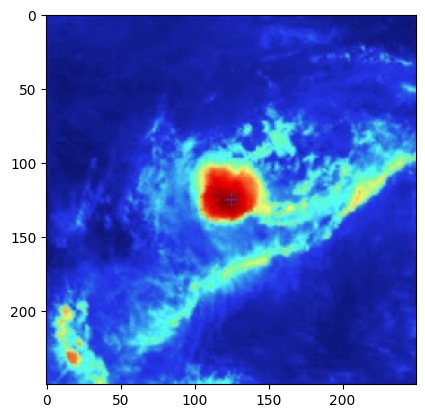

In [23]:
#print a random image from the dataset
import random
i = random.randint(0, 132)
img, label = dataset[i]
size = img.shape
print(f"INTENSITY: {label} KNOTS")
print(f"SIZE: {size}\n")
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [31]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Conv2d(3, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Flatten(),
        nn.Linear(784, 1),
    )
  def forward(self, x):
    return self.model(x)

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [33]:
model = Model().to(device)
summary(model, (3, 250, 250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 256, 250, 250]           7,168
       BatchNorm2d-2        [-1, 256, 250, 250]             512
              ReLU-3        [-1, 256, 250, 250]               0
            Conv2d-4        [-1, 256, 250, 250]         590,080
       BatchNorm2d-5        [-1, 256, 250, 250]             512
              ReLU-6        [-1, 256, 250, 250]               0
         MaxPool2d-7        [-1, 256, 125, 125]               0
            Conv2d-8        [-1, 128, 125, 125]         295,040
       BatchNorm2d-9        [-1, 128, 125, 125]             256
             ReLU-10        [-1, 128, 125, 125]               0
           Conv2d-11        [-1, 128, 125, 125]         147,584
      BatchNorm2d-12        [-1, 128, 125, 125]             256
             ReLU-13        [-1, 128, 125, 125]               0
        MaxPool2d-14          [-1, 128,

In [34]:
loss_per_iteration = []
def train_batch(epochs, model, criterion, optimizer, train_loader):
  total = 0
  correct = 0 
  for i in range(epochs):
    train_loss = 0.0
    for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      labels = torch.unsqueeze(labels, 1)
      loss = criterion(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_loss = train_loss + loss.item()

    print(f"Epoch: {i}/{epochs} Loss: {train_loss/len(train_loader):.5f} ")
    loss_per_iteration.append(train_loss/len(train_loader))

In [35]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May 29 01:09:16 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.44                 Driver Version: 552.44         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   53C    P8             20W /   55W |    2837MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [36]:
model = Model().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr =0.001)

train_batch(epochs=50,
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            train_loader = data_loader)

Epoch: 0/50 Loss: 2510.47649 
Epoch: 1/50 Loss: 762.01853 
Epoch: 2/50 Loss: 435.44185 
Epoch: 3/50 Loss: 409.22440 
Epoch: 4/50 Loss: 413.80052 
Epoch: 5/50 Loss: 392.24957 
Epoch: 6/50 Loss: 386.69184 
Epoch: 7/50 Loss: 347.60582 
Epoch: 8/50 Loss: 383.88152 
Epoch: 9/50 Loss: 340.31316 
Epoch: 10/50 Loss: 301.43048 
Epoch: 11/50 Loss: 320.93568 
Epoch: 12/50 Loss: 318.63157 
Epoch: 13/50 Loss: 297.29168 
Epoch: 14/50 Loss: 275.72694 
Epoch: 15/50 Loss: 262.63660 
Epoch: 16/50 Loss: 262.79748 
Epoch: 17/50 Loss: 236.45967 
Epoch: 18/50 Loss: 229.50228 
Epoch: 19/50 Loss: 221.86736 
Epoch: 20/50 Loss: 193.97542 
Epoch: 21/50 Loss: 196.18914 
Epoch: 22/50 Loss: 258.77901 
Epoch: 23/50 Loss: 173.51758 
Epoch: 24/50 Loss: 183.96250 
Epoch: 25/50 Loss: 144.88891 
Epoch: 26/50 Loss: 164.33269 
Epoch: 27/50 Loss: 151.83501 
Epoch: 28/50 Loss: 156.15638 
Epoch: 29/50 Loss: 142.23081 
Epoch: 30/50 Loss: 113.48320 
Epoch: 31/50 Loss: 109.33759 
Epoch: 32/50 Loss: 90.51105 
Epoch: 33/50 Loss: 8

In [37]:
model.eval()

Model(
  (model): Sequential(
    (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding

In [38]:
img = cv2.imread('./cyclone_ir.jpg')
img = np.array(img)
totensor = transforms.ToTensor()
img = totensor(img)
resize = transforms.Resize(size=(250, 250))
img = resize(img)
img = torch.unsqueeze(img, 0)
img = img.to(device)
model(img)

tensor([[74.7646]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [39]:
saved_path = './saved_modelcyclonet'
torch.save(model.state_dict(), saved_path)